In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tf_model.h5
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/tokenizer_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/pytorch_model.bin
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/vocab.txt
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/flax_model.msgpack
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/._bert_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/bert_config.json
/kaggle/input/huggingface-bert-variants/bert-large-uncased/bert-large-uncased/whole-word-masking/pytorch_model.bin
/

In [2]:
import pandas as pd
import numpy as np
import os

import transformers
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from transformers import TFBertModel
from transformers import AutoTokenizer


tf.config.experimental_run_functions_eagerly(False)

2022-07-19 20:54:51.917404: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-19 20:54:51.917570: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
data = pd.read_csv("../input/feedback-prize-effectiveness/train.csv")
data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


In [4]:
def bert_encoder(texts,tokenizer,max_len = 256):
    input_ids  = list()
    token_type_ids = list()
    attention_mask = list()
    
    for text in texts:
        token  = tokenizer(text,max_length = 256,truncation = True,padding = 'max_length',add_special_tokens = True)
        input_ids.append(token['input_ids'])
        token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
        
    return np.array(input_ids),np.array(token_type_ids),np.array(attention_mask)

In [5]:
# Bert Tokenizer
model_path = '../input/huggingface-bert-variants/bert-base-cased/bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)

# tokenizer = transformers.BertTokenizer.from_pretrained(model_path)
tokenizer.save_pretrained(".")

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [6]:
SEP = tokenizer.sep_token
data['inputs'] = data.discourse_type + SEP + data.discourse_text

In [7]:
data['inputs'].iloc[0]

"Lead[SEP]Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. "

In [8]:
# creating label

new_label = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}
data = data.replace(new_label)
data = data.rename(columns={"discourse_effectiveness":'label'})

In [9]:
data.head()

,discourse_id,essay_id,discourse_text,discourse_type,label,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,1,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,1,"Position[SEP]On my perspective, I think that t..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,1,Claim[SEP]I think that the face is a natural l...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,1,"Evidence[SEP]If life was on Mars, we would kno..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,1,Counterclaim[SEP]People thought that the face ...


In [10]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-07-19 20:55:02.615580: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-19 20:55:02.619761: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-07-19 20:55:02.619825: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-19 20:55:02.619875: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6c28560b3017): /proc/driver/nvidia/version does not exist
2022-07-19 20:55:02.624118: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [11]:
# split dataset
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(data['inputs'], data['label'], test_size=0.2, random_state=42)

In [12]:
X_train = bert_encoder(X_train.astype(str),tokenizer)
X_valid = bert_encoder(X_valid.astype(str),tokenizer)

y_train = y_train.values
y_valid = y_valid.values

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# batch_size = 8,lr = 3e-6,max_len = 512,
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train,y_train)).repeat().shuffle(2048).batch(16).prefetch(AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((X_valid,y_valid)).batch(16).cache().prefetch(AUTOTUNE))

In [14]:
train_dataset

<PrefetchDataset shapes: (((None, 256), (None, 256), (None, 256)), (None,)), types: ((tf.int64, tf.int64, tf.int64), tf.int64)>

In [15]:
def build_model(model_bert,max_len = 256):
    input_ids =      Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    sequence_output = model_bert.bert(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    clf_output = sequence_output[:, 0, :]
    clf_output = Dropout(0.1)(clf_output)
    out = Dense(3,activation = 'softmax')(clf_output)

    model = Model(inputs = [input_ids,token_type_ids,attention_mask],outputs = out)
    model.compile(Adam(learning_rate = 1e-05),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
    
    return model
    

In [16]:
with tpu_strategy.scope():
    transformer_layer = (TFBertModel.from_pretrained('../input/huggingface-bert-variants/bert-base-cased/bert-base-cased'))
    model = build_model(transformer_layer, max_len=256)
    
    save_best = tf.keras.callbacks.ModelCheckpoint("./Model.h5", monitor='val_accuracy',save_best_only=True, verbose=1)
    
    model.summary()
    print('\n\nModel Training..........................................\n')
    model.fit(train_dataset,steps_per_epoch=350, validation_data=valid_dataset, epochs=50, callbacks=[save_best])


Some layers from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


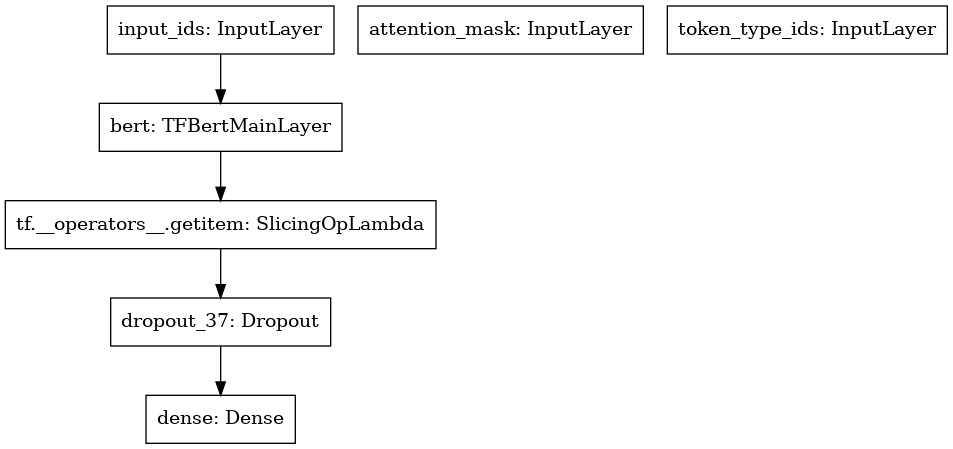

In [17]:
tf.keras.utils.plot_model(model)

In [18]:
model = tf.keras.models.load_model('./Model.h5')

In [19]:
test = pd.read_csv("../input/feedback-prize-effectiveness/test.csv")
test['text'] = test.discourse_type + '[SEP]' +test.discourse_text
test.head()

,discourse_id,essay_id,discourse_text,discourse_type,text
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead,Lead[SEP]Making choices in life can be very di...
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position,Position[SEP]Seeking multiple opinions can hel...
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim,Claim[SEP]it can decrease stress levels
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim,Claim[SEP]a great chance to learn something new
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim,Claim[SEP]can be very helpful and beneficial.


In [20]:
test_text = bert_encoder(test.text.astype(str), tokenizer)

In [21]:
submission_data = pd.read_csv("../input/feedback-prize-effectiveness/sample_submission.csv")
submission_data.head()

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.20,0.60,0.40
1,5a88900e7dc1,3.00,6.00,1.00
2,9790d835736b,1.00,2.00,3.00
3,75ce6d68b67b,0.33,0.34,0.33
4,93578d946723,0.01,0.24,0.47


In [22]:
preds = model.predict(test_text, verbose=1)
preds

1/1 [==============================] - 3s 3s/step


array([[1.2129057e-03, 3.1201243e-01, 6.8677467e-01],
       [7.0737731e-03, 9.3418837e-01, 5.8737952e-02],
       [6.8863545e-04, 4.1169927e-01, 5.8761209e-01],
       [1.3643203e-02, 6.1831081e-01, 3.6804602e-01],
       [7.3283170e-03, 4.3066686e-01, 5.6200486e-01],
       [2.9368505e-03, 5.3389108e-01, 4.6317208e-01],
       [2.4850819e-05, 4.5321386e-02, 9.5465380e-01],
       [4.9391296e-04, 1.7405912e-01, 8.2544696e-01],
       [1.6661234e-02, 8.3089256e-01, 1.5244624e-01],
       [1.0399574e-04, 4.0121433e-01, 5.9868169e-01]], dtype=float32)

In [23]:
preds > 0.5

array([[False, False,  True],
       [False,  True, False],
       [False, False,  True],
       [False,  True, False],
       [False, False,  True],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False,  True, False],
       [False, False,  True]])

In [24]:
submission_data['Ineffective'] = preds[:,0]
submission_data['Adequate'] = preds[:,1]
submission_data['Effective'] = preds[:,2]
submission_data

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.001213,0.312012,0.686775
1,5a88900e7dc1,0.007074,0.934188,0.058738
2,9790d835736b,0.000689,0.411699,0.587612
3,75ce6d68b67b,0.013643,0.618311,0.368046
4,93578d946723,0.007328,0.430667,0.562005
5,2e214524dbe3,0.002937,0.533891,0.463172
6,84812fc2ab9f,0.000025,0.045321,0.954654
7,c668ff840720,0.000494,0.174059,0.825447
8,739a6d00f44a,0.016661,0.830893,0.152446
9,bcfae2c9a244,0.000104,0.401214,0.598682


In [25]:
submission_data.to_csv("submission.csv", index=False)

In [26]:
pd.read_csv("submission.csv")

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.001213,0.312012,0.686775
1,5a88900e7dc1,0.007074,0.934188,0.058738
2,9790d835736b,0.000689,0.411699,0.587612
3,75ce6d68b67b,0.013643,0.618311,0.368046
4,93578d946723,0.007328,0.430667,0.562005
5,2e214524dbe3,0.002937,0.533891,0.463172
6,84812fc2ab9f,0.000025,0.045321,0.954654
7,c668ff840720,0.000494,0.174059,0.825447
8,739a6d00f44a,0.016661,0.830893,0.152446
9,bcfae2c9a244,0.000104,0.401214,0.598682
